# 1. Example: Creating a Model in DataAssimBench

In this notebook, we'll introduce the basics of how to create a model object in DataAssimBench and use generated data to train and evaluate it. We'll use Lorenz63 data generator and a reservoir computing model

In [1]:
from dabench import data
import matplotlib.pyplot as plt

In [2]:
l63 = data.Lorenz63()
l63.generate(n_steps=1000)

### Part I: Import dabench.model

The "model sub-package is dabench's interface for creating and using models.

In [3]:
from rc import RCModel

In [4]:
model = RCModel(system_dim=3, reservoir_dim=100, input_dim=3, sparse_adj_matrix=False, sparsity=0.5)

In [5]:
model.weights_init()

In [6]:
model.state = model.generate(l63.values)

In [7]:
model.train(l63)

(3, 100) (100, 100)


In [8]:
model.Win.shape

(100, 3)

In [9]:
model.Wout.shape

(100, 3)

In [25]:
out_obj = model.predict(l63, initial_index=200, spinup_steps=100)

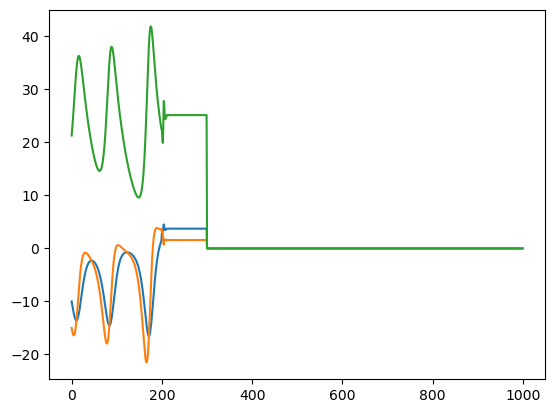

In [23]:
plt.plot(out_obj.values)

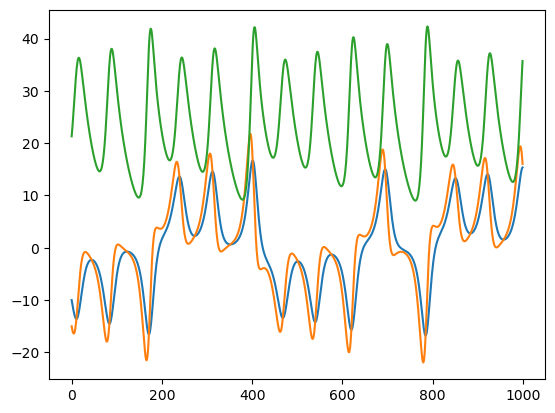

In [12]:
plt.plot(l63.values)

### Part II: Train Reservoir Computing Model

We'll use a Reservoir Computing model, a twist on a recurrent neural network. The "reservoirpy" package makes it easy to build one of these models. To install, use:

`pip install reservoirpy`


In [3]:
import reservoirpy
import matplotlib.pyplot as plt

In [4]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=1000, lr=0.1, sr=0.8)
readout = Ridge(output_dim=3, ridge=1e-4)
esn = reservoir >> readout

In [20]:
l63 = data.Lorenz63()
l63.generate(n_steps=50000)

In [21]:
train = l63.values[:48000]
val = l63.values[48000:49000]
test = l63.values[49000:]

In [22]:
esn.fit(train[:-1], train[1:], warmup=200)

Running Model-0:   0%|                                                                                                                                                                         | 0/1 [00:00<?, ?it/s]
Running Model-0: 90it [00:00, 898.73it/s]                                                                                                                                                                            
Running Model-0: 180it [00:00, 770.58it/s]
Running Model-0: 264it [00:00, 796.30it/s]
Running Model-0: 349it [00:00, 816.11it/s]
Running Model-0: 432it [00:00, 741.84it/s]
Running Model-0: 508it [00:00, 745.14it/s]
Running Model-0: 588it [00:00, 758.43it/s]
Running Model-0: 668it [00:00, 770.83it/s]
Running Model-0: 748it [00:00, 777.44it/s]
Running Model-0: 827it [00:01, 768.92it/s]
Running Model-0: 905it [00:01, 764.89it/s]
Running Model-0: 984it [00:01, 770.88it/s]
Running Model-0: 1062it [00:01, 769.90it/s]
Running Model-0: 1140it [00:01, 759.08it/s]
Running Mod

Running Model-0: 27557it [00:34, 764.71it/s]
Running Model-0: 27638it [00:34, 776.20it/s]
Running Model-0: 27725it [00:34, 801.32it/s]
Running Model-0: 27807it [00:34, 805.45it/s]
Running Model-0: 27889it [00:35, 807.82it/s]
Running Model-0: 27970it [00:35, 786.03it/s]
Running Model-0: 28049it [00:35, 785.79it/s]
Running Model-0: 28131it [00:35, 794.76it/s]
Running Model-0: 28211it [00:35, 796.15it/s]
Running Model-0: 28291it [00:35, 750.11it/s]
Running Model-0: 28367it [00:35, 719.57it/s]
Running Model-0: 28447it [00:35, 739.94it/s]
Running Model-0: 28536it [00:35, 782.67it/s]
Running Model-0: 28619it [00:35, 795.90it/s]
Running Model-0: 28705it [00:36, 813.92it/s]
Running Model-0: 28790it [00:36, 824.11it/s]
Running Model-0: 28873it [00:36, 825.25it/s]
Running Model-0: 28956it [00:36, 809.13it/s]
Running Model-0: 29038it [00:36, 796.02it/s]
Running Model-0: 29118it [00:36, 794.58it/s]
Running Model-0: 29201it [00:36, 802.94it/s]
Running Model-0: 29287it [00:36, 817.85it/s]
Running Mo

Fitting node Ridge-0...


'Model-0': Model('Reservoir-0', 'Ridge-0')

In [23]:
predictions = esn.run(val)

Running Model-0: 1000it [00:01, 856.27it/s]                                                                                                                                                                          


In [24]:
predictions.shape

(1000, 3)

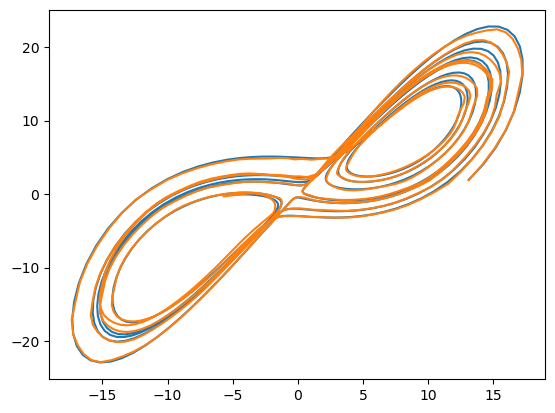

In [25]:
plt.plot(val[1:,0], val[1:,1])
plt.plot(predictions[:-1,0],predictions[:-1,1])
plt.show()



### Part III: Wrap RC model in DABench Model Object

In [26]:
class RC_model(model.Model):
    def forecast(self, state_vec):
        new_vals = esn.call(state_vec.values)
        
        new_vec = vector.StateVector(values = new_vals)
        
        return new_vec

In [27]:
rc_model = RC_model()

In [28]:
all_vals = []
state_vec = vector.StateVector(values=np.array([test[0]]))
all_vals.append(state_vec.values)
for i in range(test.shape[0]):
    state_vec = rc_model.forecast(state_vec)
    all_vals.append(state_vec.values)

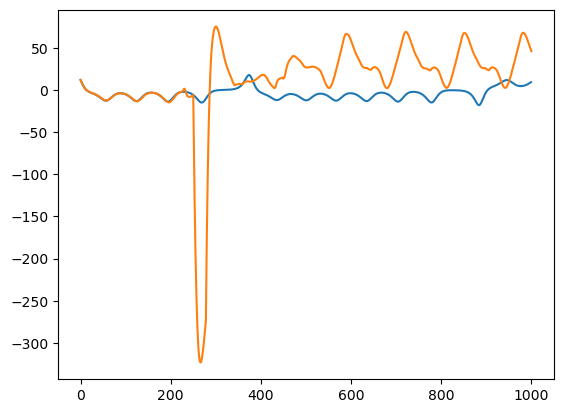

In [29]:
plt.plot(test[:,0])
plt.plot(np.array(all_vals).reshape(-1,3)[:,0])


### Part IV: Wrap RC model in DABench Model Object using state vec to store reservoir state

In [11]:
class RC_model(model.Model):
    def forecast(self, state_vec):
        state_dict = {}
        new_vals = esn.call(state_vec.values,
                            from_state=state_vec.res_state)
        
        new_vec = vector.StateVector(values = new_vals)
        for node in esn.nodes:
            state_dict[node.name] = node.state()
        
        new_vec.res_state = state_dict
        
        return new_vec

In [12]:
rc_model = RC_model()

In [13]:
state_dict = {}
for node in esn.nodes:
    state_dict[node.name] = node.state()
state_vec = vector.StateVector(values=np.array([test[0]]))
state_vec.res_state = state_dict

In [14]:
all_vals = []
all_vals.append(state_vec.values)

In [15]:
for i in range(test.shape[0]):
    state_vec = rc_model.forecast(state_vec)
    all_vals.append(state_vec.values)

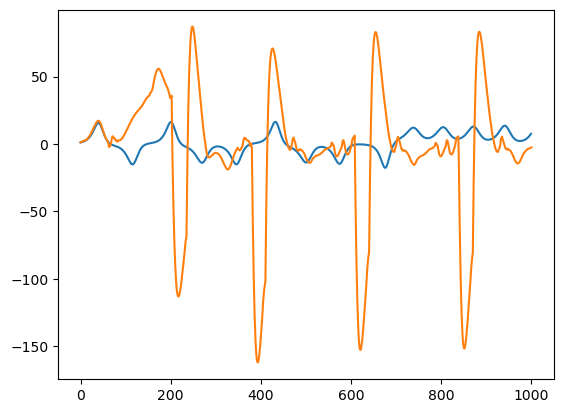

In [19]:
plt.plot(test[:,0])
plt.plot(np.array(all_vals).reshape(-1,3)[:,0])